In [1]:
from periodicLatticeSolver import PeriodicLatticeSolver
from minimizer import Minimizer
import numpy as np
from FloorPlanClass import FloorPlan
from plotter import Plotter
PLS = PeriodicLatticeSolver(200, .02)
PLS.add_Injector()

L1 = PLS.Variable('L1', varMin=.01, varMax=.5)
L2= PLS.Variable('L2', varMin=.01, varMax=.5)
L3 =PLS.Variable('L3', varMin=.01, varMax=.5)
L4= PLS.Variable('L4', varMin=.01, varMax=.5)

Bp1 = PLS.Variable('Bp1', varMin=.1, varMax=.45)
Bp2 = PLS.Variable('Bp2', varMin=.1, varMax=.45)
Bp3 = PLS.Variable('Bp3', varMin=.1, varMax=.45)
Bp4 = PLS.Variable('Bp4', varMin=.1, varMax=.45)

rp1 = PLS.Variable('rp1', varMin=.005, varMax=.03)
rp2 = PLS.Variable('rp2', varMin=.005, varMax=.03)
rp3 = PLS.Variable('rp3', varMin=.005, varMax=.03)
rp4 = PLS.Variable('rp4', varMin=.005, varMax=.03)

r0=PLS.Variable('r0',varMin=1,varMax=1.25)
TL1=PLS.Variable('TL1',varMin=.5,varMax=1.5)
TL2=PLS.Variable('TL2',varMin=.5,varMax=1.5)


PLS.set_Track_Length(TL1=TL1,TL2=TL2)
PLS.begin_Lattice()

PLS.add_Bend(None, r0, .45)
PLS.add_Drift(L=.03)
PLS.add_Lens(L4, Bp4, rp4)
PLS.add_Drift()
PLS.add_Combiner()
PLS.add_Drift()
PLS.add_Lens(L1, Bp1,rp1)
PLS.add_Drift(L=.03)
PLS.add_Bend(None, r0, .45)
PLS.add_Drift(L=.03)
PLS.add_Lens(L2, Bp2, rp2)
PLS.add_Drift()
PLS.add_Lens(L3, Bp3, rp3)
PLS.add_Drift(L=.03)
PLS.end_Lattice()

Lattice model completed


100%|██████████| 2000/2000 [3:15:20<00:00,  5.86s/it]


minCost for each thread:  [1.58564719 1.52879286 1.25319083 1.3082445  1.42439907 1.18889727
 1.25427998 1.41493035 1.38703372 1.40398887 1.39653568 1.20436312
 1.19143259 1.18114817 1.62988    1.28867157 1.38308133 1.45103999
 1.34878298 1.32682974 1.37852455 1.32643363 1.38759743 1.34113911
 1.39815305 1.22373172 1.18288538 1.17017024 1.34735827 1.38348261
 1.16473641 1.18555412]


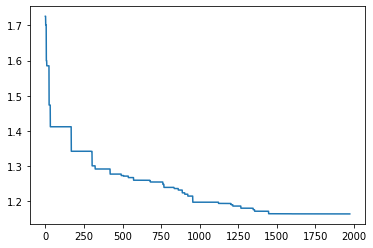

[ 0.49991419  0.49422425  0.49775958  0.32267748  0.24978214  0.24753887
  0.22425928  0.10406031  0.02977845  0.02999994  0.02903007  0.01353961
  1.10406121  0.83182171  0.96409082  0.19996565  0.11984063 -0.01615682] 1.1647364051904219
percent particles surviving (x,y): 51.8, 16.7
[ 0.49991419  0.49422425  0.49775958  0.32267748  0.24978214  0.24753887
  0.22425928  0.10406031  0.02977845  0.02999994  0.02903007  0.01353961
  1.10406121  0.83182171  0.96409082  0.19996565  0.11984063 -0.01615682] 1.1647364051904219
done
Total time 195 minutes and 23 seconds


In [2]:
minimizer=Minimizer(PLS)
minimizer.find_Global_Min(mut=.75, crossPop=.7, iterations=2000, popPerDim=20,strategy='best/1')

[0.4999 0.4942 0.4978 0.3227 0.2498 0.2475 0.2243 0.1041 0.0298 0.03
 0.029  0.0135 1.1041 0.8318 0.9641]


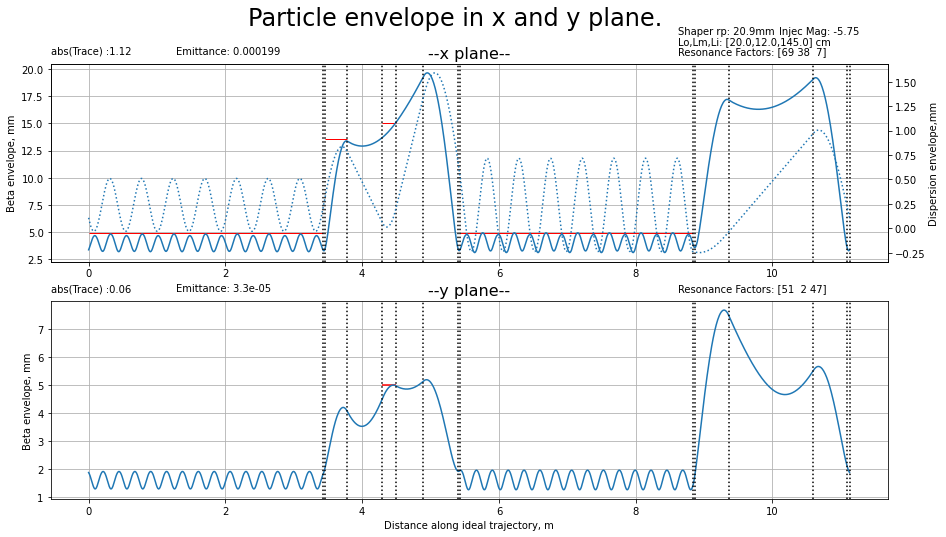

In [5]:
plotter=Plotter(PLS)
plotter.plot(sol=minimizer.sol)

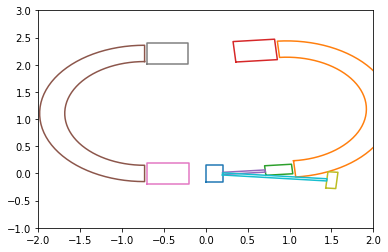

4.0

In [6]:
floorPlan=FloorPlan(PLS)
floorPlan.show_Floor_Plan(sol=minimizer.sol)
floorPlan.calculate_Cost()

In [18]:
Lo=minimizer.sol.Lo
Lm=minimizer.sol.Lm
s0=minimizer.sol.sOffset
minimizer.PLS.injector.rpFunc(Lo,Lm,0)

0.020855379106132062